<a href="https://colab.research.google.com/github/gunjanak/Reinforcement_Learning/blob/main/mountainCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Function Approximation

For problems with very large number of states it will not be feasible for our agent to use table to record the value of all the action for each state and make its policy accordingly.

In Function approximation agent learns a function which will approxmately give it best action for particular state.

In this example we will use neural network to estimate the function.
The goal of FA is to use a set of features to estimate the Q values via a regression model.Using neural networks as the estimation model, we increase the regression power by adding flexibility (multiple layers in neural networks) and non-linearity introduced by non-linear activation in hidden layers. The remaining part of the Q-learning model is very similar to the one with linear approximation. We also use gradient descent to train the
network. The ultimate goal of learning is to find the optimal weights of the network to best approximate the state-value function, V(s), for each possible action. The loss function we are trying to minimize is also the mean squared error between the actual value and the estimated value.

In [1]:
'''
Source codes for PyTorch 1.0 Reinforcement Learning (Packt Publishing)
Chapter 6: Scaling up Learning with Function Approximation
Author: Yuxi (Hayden) Liu
'''

import torch
from torch.autograd import Variable
import math


class Estimator():
    def __init__(self, n_feat, n_state, n_action, n_hidden=50, lr=0.05):
        self.w, self.b = self.get_gaussian_wb(n_feat, n_state)
        self.n_feat = n_feat
        self.models = []
        self.optimizers = []
        self.criterion = torch.nn.MSELoss()

        for _ in range(n_action):
          #Defining the neural network model
            model = torch.nn.Sequential(
                        torch.nn.Linear(n_feat, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, 1)
                )

            self.models.append(model)
            #using Adam as an optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr)
            self.optimizers.append(optimizer)



    def get_gaussian_wb(self, n_feat, n_state, sigma=.2):
        """
        Generate the coefficients of the feature set from Gaussian distribution
        @param n_feat: number of features
        @param n_state: number of states
        @param sigma: kernel parameter
        @return: coefficients of the features
        """
        torch.manual_seed(0)
        w = torch.randn((n_state, n_feat)) * 1.0 / sigma
        b = torch.rand(n_feat) * 2.0 * math.pi
        return w, b

    def get_feature(self, s):
        """
        Generate features based on the input state
        @param s: input state
        @return: features
        """
        features = (2.0 / self.n_feat) ** .5 * torch.cos(
            torch.matmul(torch.tensor(s).float(), self.w) + self.b)
        return features


    def update(self, s, a, y):
        """
        Update the weights for the linear estimator with the given training sample
        @param s: state
        @param a: action
        @param y: target value
        """
        features = Variable(self.get_feature(s))


        y_pred = self.models[a](features)

        loss = self.criterion(y_pred, Variable(torch.Tensor([y])))

        self.optimizers[a].zero_grad()
        loss.backward()

        self.optimizers[a].step()



    def predict(self, s):
        """
        Compute the Q values of the state using the learning model
        @param s: input state
        @return: Q values of the state
        """
        features = self.get_feature(s)
        with torch.no_grad():
            return torch.tensor([model(features) for model in self.models])

#Mountain Car

Mountain Car ( https:/​ / ​ gym.​ openai.​ com/​ envs/​ MountainCar-​ v0/​ ) is a typical Gym
environment with continuous states. As shown in the following diagram, its goal is to get
the car to the top of the hill:

On a one-dimensional track, the car is positioned between -1.2 (leftmost) and 0.6
(rightmost), and the goal (yellow flag) is located at 0.5. The engine of the car is not strong
enough to drive it to the top in a single pass, so it has to drive back and forth to build up
momentum. Hence, there are three discrete actions for each step:
Push left (0)
No push (1)
Push right (2)

And there are two states of the environment:
Position of the car: this is a continuous variable from -1.2 to 0.6.
Velocity of the car: this is a continuous variable from -0.07 to 0.07.
The reward associated with each step is -1, until the car reaches the goal (a position of 0.5).
An episode ends when the car reaches the goal position (obviously), or after 200 steps.

In [2]:
import gym
import torch

from collections import deque
import random

env = gym.envs.make("MountainCar-v0")

In [3]:
#connecting python script to gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        probs = torch.ones(n_action) * epsilon / n_action
        q_values = estimator.predict(state)
        best_action = torch.argmax(q_values).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function


#Q learning with experience Replay

Experience replay means we store the agent's experiences during an episode instead of
running Q-learning. The learning phase with experience replay becomes two phases:
gaining experience and updating models based on the experience obtained after an episode
finishes.Specifically, the experience (also called the buffer, or memory) includes the past
state, the action taken, the reward received, and the next state for individual steps in an
episode.

In [5]:
def q_learning(env, estimator, n_episode, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=.99):
    """
    Q-Learning algorithm using Function Approximation, with experience replay
    @param env: Gym environment
    @param estimator: Estimator object
    @param replay_size: number of samples we use to update the model each time
    @param n_episode: number of episodes
    @param gamma: the discount factor
    @param epsilon: parameter for epsilon_greedy
    @param epsilon_decay: epsilon decreasing factor
    """
    for episode in range(n_episode):
        policy = gen_epsilon_greedy_policy(estimator, epsilon * epsilon_decay ** episode, n_action)
        state = env.reset()
        is_done = False
        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)
            total_reward_episode[episode] += reward

            if is_done:
                break

            q_values_next = estimator.predict(next_state)
            td_target = reward + gamma * torch.max(q_values_next)


            #appending state, action and td_target in experience replay buffer
            memory.append((state, action, td_target))

            state = next_state

        #Extracting random data from memory
        replay_data = random.sample(memory, min(replay_size, len(memory)))
        
        #Using that random data to update the estimator
        for state, action, td_target in replay_data:
            estimator.update(state, action, td_target)

        if(episode%100 == 0):
          print("Episode: {} Reward: {}".format(episode,total_reward_episode[episode]))



In [17]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 200
n_hidden = 50
lr = 0.001
#Instatiating the Estimator object
estimator = Estimator(n_feature, n_state, n_action, n_hidden, lr)

In [18]:
#Defining the memory for experience buffer
memory = deque(maxlen=300)
n_episode = 500
replay_size = 200
total_reward_episode = [0] * n_episode

q_learning(env, estimator, n_episode, replay_size, epsilon=0.1)

Episode: 0 Reward: -200.0
Episode: 100 Reward: -200.0
Episode: 200 Reward: -200.0
Episode: 300 Reward: -149.0
Episode: 400 Reward: -162.0


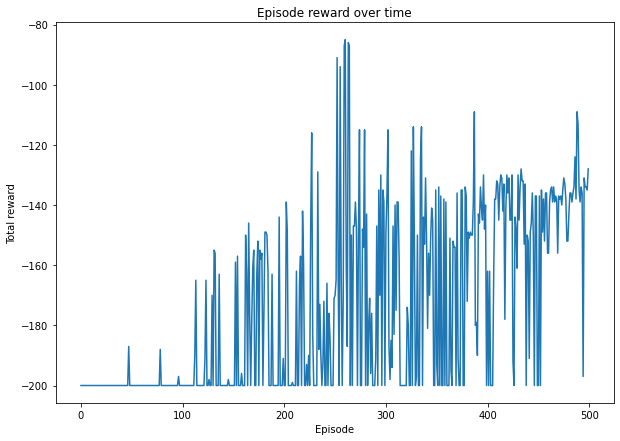

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [20]:

#Using the trained estimator to run one episode of the MountainCar
state = env.reset()
is_done = False
total_reward_episode = 0
while not is_done:
  q_values = estimator.predict(state)
  best_action = torch.argmax(q_values).item()
  next_state, reward, is_done, _ = env.step(best_action)
  state = next_state
  total_reward_episode += reward


print(total_reward_episode)



-133.0


#Storing trained estimator object for future use

In [21]:
import pickle

In [22]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [23]:
save_object(estimator, 'estimator.pkl')

#Loading the object

In [24]:
file_to_read = open("/content/estimator.pkl", "rb")

loaded_estimator = pickle.load(file_to_read)

In [25]:
#Playing with the loaded object
state = env.reset()
is_done = False
total_reward_episode = 0
while not is_done:
  q_values = loaded_estimator.predict(state)
  best_action = torch.argmax(q_values).item()
  next_state, reward, is_done, _ = env.step(best_action)
  state = next_state
  total_reward_episode += reward


print(total_reward_episode)



-138.0
